In [1]:
"""
Fake Job Detection using NLP
=============================
A text classification project to detect fraudulent job postings using the
EMSCAD dataset. Applies NLP preprocessing (tokenization, stop-word removal,
TF-IDF vectorization) and trains Logistic Regression & Random Forest
classifiers.

Author : Rohit Yadav
Date   : Nov 2024 – Jan 2025
"""

'\nFake Job Detection using NLP\n=============================\nA text classification project to detect fraudulent job postings using the\nEMSCAD dataset. Applies NLP preprocessing (tokenization, stop-word removal,\nTF-IDF vectorization) and trains Logistic Regression & Random Forest\nclassifiers.\n\nAuthor : Rohit Yadav\nDate   : Nov 2024 – Jan 2025\n'

In [2]:
# ============================================================
# 0. INSTALL DEPENDENCIES
# ============================================================
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
    "nltk", "scikit-learn", "pandas", "matplotlib", "seaborn", "wordcloud"])

0

In [3]:
# ============================================================
# 1. IMPORTS
# ============================================================
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [5]:
# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score,
)

In [7]:
# Download NLTK data
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

[nltk_data] Zip Slip blocked: punkt/


[nltk_data] Zip Slip blocked: punkt_tab/
[nltk_data] Zip Slip blocked: stopwords/


True

In [8]:
# Plot settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

In [9]:
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [10]:
# ============================================================
# 2. DATA LOADING
# ============================================================
print("\n" + "=" * 60)
print("2. DATA LOADING")
print("=" * 60)


2. DATA LOADING


In [11]:
df = pd.read_csv("fake_job_postings.csv")
print(f"Dataset shape: {df.shape}")
print(f"Total job postings: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")

Dataset shape: (17880, 18)
Total job postings: 17,880
Total features: 18


In [12]:
print("\n📋 Column names:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")


📋 Column names:
    1. job_id
    2. title
    3. location
    4. department
    5. salary_range
    6. company_profile
    7. description
    8. requirements
    9. benefits
   10. telecommuting
   11. has_company_logo
   12. has_questions
   13. employment_type
   14. required_experience
   15. required_education
   16. industry
   17. function
   18. fraudulent


In [13]:
print("\n📊 First 5 rows:")
print(df.head())


📊 First 5 rows:
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         desc

In [14]:
# ============================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================
print("\n" + "=" * 60)
print("3. EXPLORATORY DATA ANALYSIS")
print("=" * 60)


3. EXPLORATORY DATA ANALYSIS


In [15]:
# --- 3.1 Target Distribution ---
print("\n--- 3.1 Target Distribution ---")
target_counts = df["fraudulent"].value_counts()
print(target_counts)
print(f"\nFraudulent %: {target_counts[1] / len(df) * 100:.2f}%")
print(f"Legitimate %: {target_counts[0] / len(df) * 100:.2f}%")


--- 3.1 Target Distribution ---
fraudulent
0    17014
1      866
Name: count, dtype: int64

Fraudulent %: 4.84%
Legitimate %: 95.16%


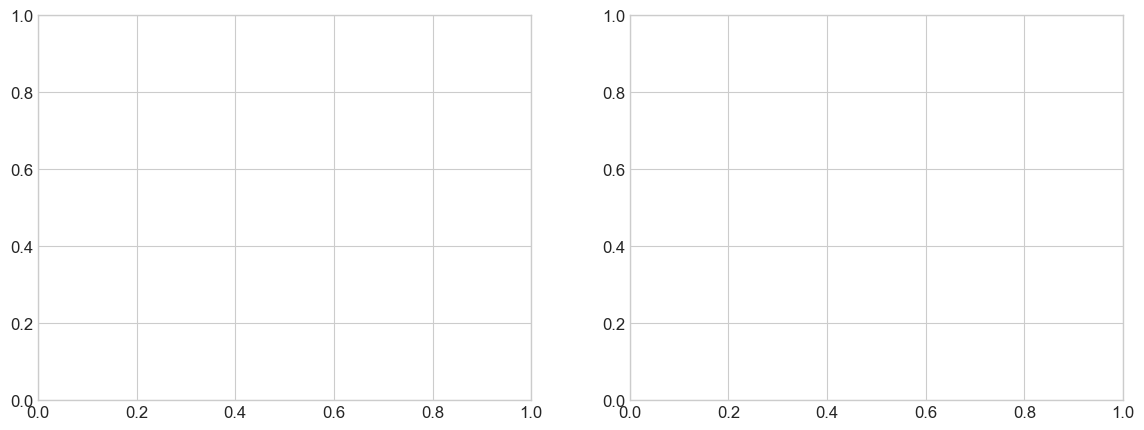

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

In [17]:
# Count plot
labels = ["Legitimate (0)", "Fraudulent (1)"]
colors = ["#2ecc71", "#e74c3c"]
axes[0].bar(labels, target_counts.values, color=colors, edgecolor="black", linewidth=0.8)
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 100, f"{v:,}", ha="center", fontweight="bold", fontsize=13)
axes[0].set_title("Distribution of Job Postings", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Count")

Text(4.444444444444445, 0.5, 'Count')

In [18]:
# Pie chart
axes[1].pie(
    target_counts.values,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=140,
    explode=(0, 0.08),
    shadow=True,
    textprops={"fontsize": 12},
)
axes[1].set_title("Fraudulent vs Legitimate", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("01_target_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 01_target_distribution.png")

<Figure size 1000x600 with 0 Axes>

📈 Saved: 01_target_distribution.png


In [19]:
# --- 3.2 Missing Values ---
print("\n--- 3.2 Missing Values Analysis ---")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"Missing Count": missing, "Missing %": missing_pct})
missing_df = missing_df[missing_df["Missing Count"] > 0].sort_values("Missing %", ascending=False)
print(missing_df)


--- 3.2 Missing Values Analysis ---
                     Missing Count  Missing %
salary_range                 15012      83.96
department                   11547      64.58
required_education            8105      45.33
benefits                      7212      40.34
required_experience           7050      39.43
function                      6455      36.10
industry                      4903      27.42
employment_type               3471      19.41
company_profile               3308      18.50
requirements                  2696      15.08
location                       346       1.94
description                      1       0.01


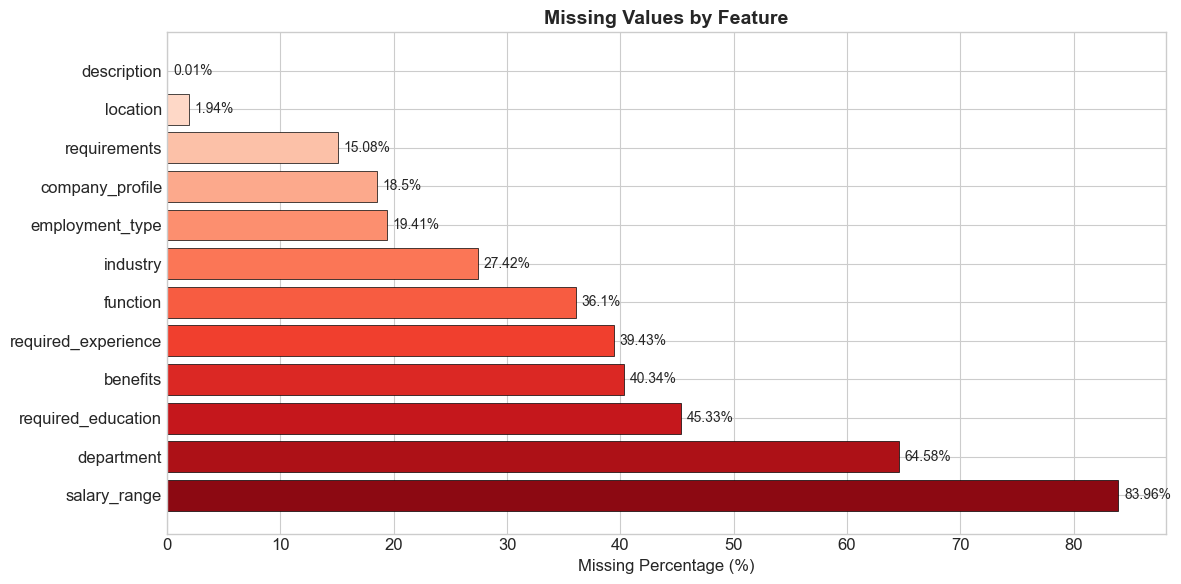

📈 Saved: 02_missing_values.png


In [20]:
plt.figure(figsize=(12, 6))
bars = plt.barh(missing_df.index, missing_df["Missing %"], color=sns.color_palette("Reds_r", len(missing_df)), edgecolor="black", linewidth=0.5)
plt.xlabel("Missing Percentage (%)")
plt.title("Missing Values by Feature", fontsize=14, fontweight="bold")
for bar, pct in zip(bars, missing_df["Missing %"]):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f"{pct}%", va="center", fontsize=10)
plt.tight_layout()
plt.savefig("02_missing_values.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 02_missing_values.png")


--- 3.3 Employment Type vs Fraud ---


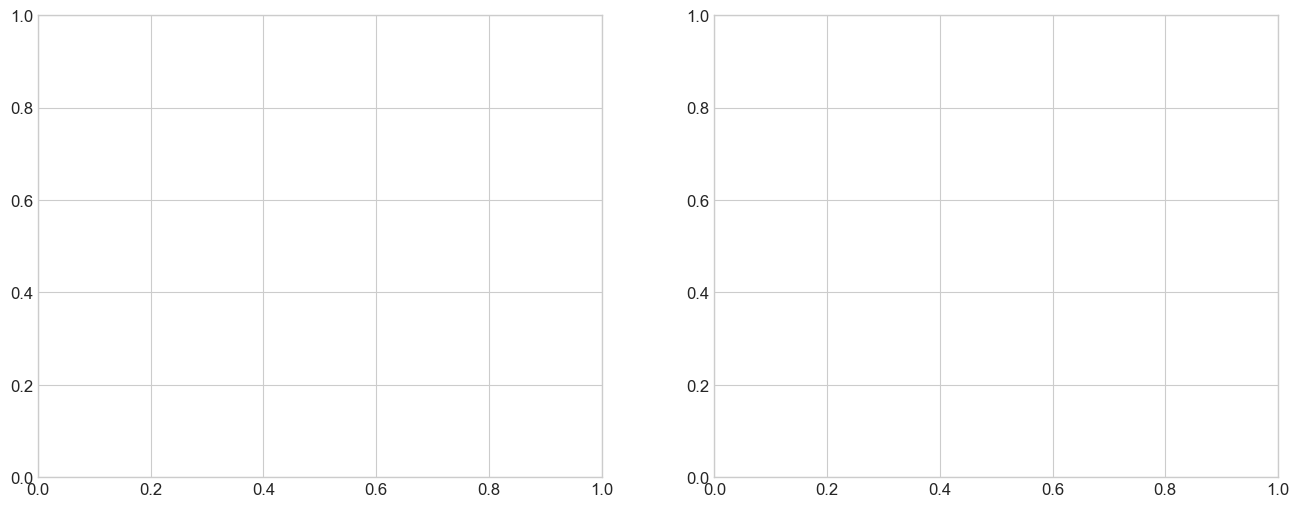

In [21]:
# --- 3.3 Employment Type Distribution ---
print("\n--- 3.3 Employment Type vs Fraud ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

In [22]:
emp_fraud = df.groupby(["employment_type", "fraudulent"]).size().unstack(fill_value=0)
emp_fraud.plot(kind="bar", ax=axes[0], color=colors, edgecolor="black", linewidth=0.5)
axes[0].set_title("Employment Type vs Fraudulent", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Count")
axes[0].legend(["Legitimate", "Fraudulent"])
axes[0].tick_params(axis="x", rotation=45)

In [23]:
# Experience vs Fraud
exp_fraud = df.groupby(["required_experience", "fraudulent"]).size().unstack(fill_value=0)
exp_fraud.plot(kind="bar", ax=axes[1], color=colors, edgecolor="black", linewidth=0.5)
axes[1].set_title("Required Experience vs Fraudulent", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Count")
axes[1].legend(["Legitimate", "Fraudulent"])
axes[1].tick_params(axis="x", rotation=45)

In [24]:
plt.tight_layout()
plt.savefig("03_categorical_analysis.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 03_categorical_analysis.png")

<Figure size 1000x600 with 0 Axes>

📈 Saved: 03_categorical_analysis.png


In [25]:
# --- 3.4 Text length analysis ---
print("\n--- 3.4 Text Length Analysis ---")
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]
for col in text_cols:
    df[f"{col}_len"] = df[col].fillna("").apply(len)


--- 3.4 Text Length Analysis ---


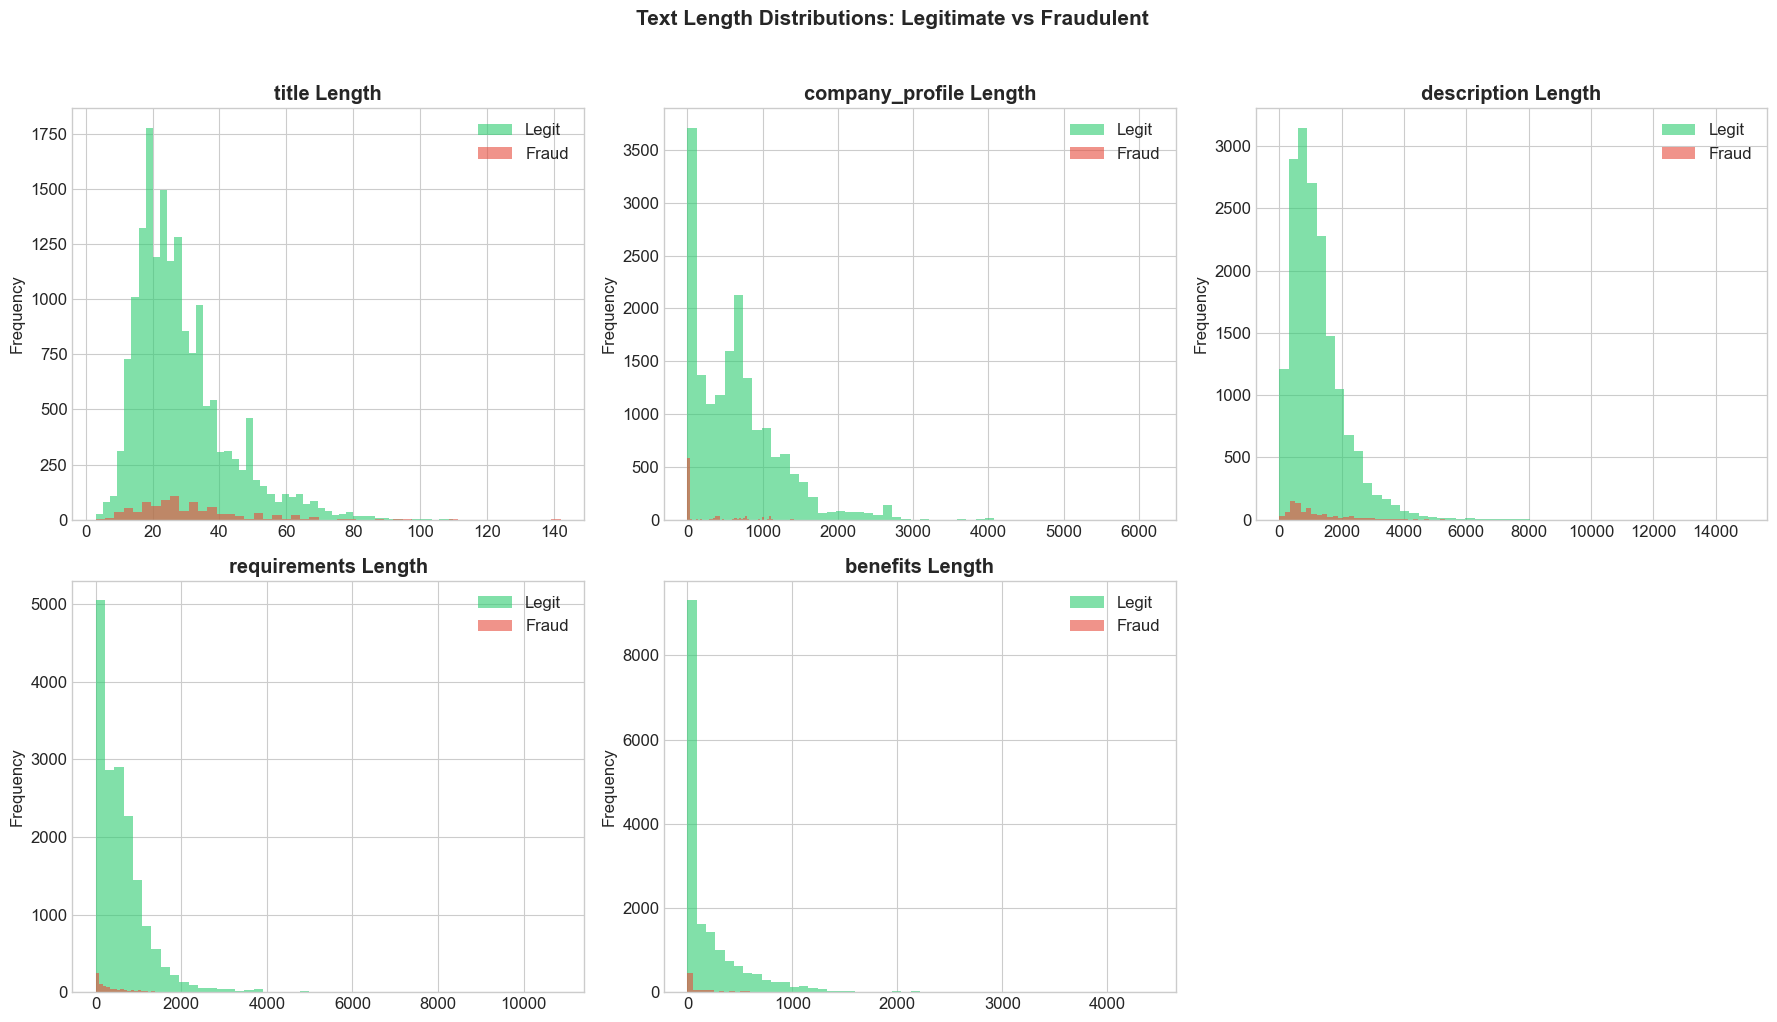

📈 Saved: 04_text_length_analysis.png


In [26]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(text_cols):
    col_len = f"{col}_len"
    df[df["fraudulent"] == 0][col_len].plot.hist(bins=50, alpha=0.6, ax=axes[i], color="#2ecc71", label="Legit")
    df[df["fraudulent"] == 1][col_len].plot.hist(bins=50, alpha=0.6, ax=axes[i], color="#e74c3c", label="Fraud")
    axes[i].set_title(f"{col} Length", fontweight="bold")
    axes[i].legend()
axes[-1].axis("off")
plt.suptitle("Text Length Distributions: Legitimate vs Fraudulent", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("04_text_length_analysis.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 04_text_length_analysis.png")


--- 3.5 Logo & Questions vs Fraud ---


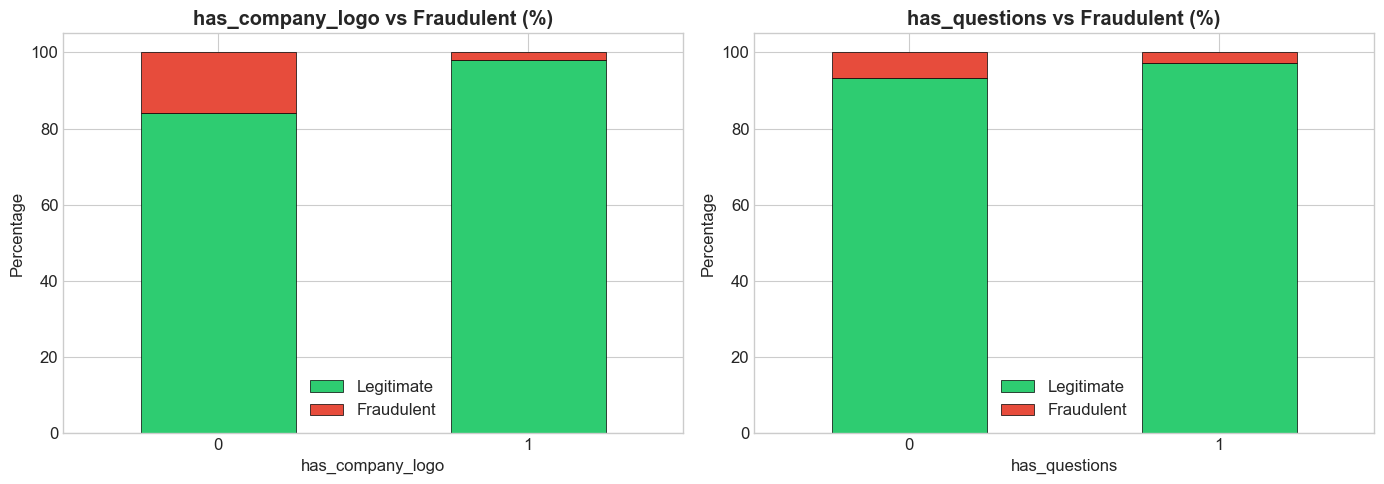

📈 Saved: 05_binary_features.png


In [27]:
# --- 3.5 has_company_logo & has_questions ---
print("\n--- 3.5 Logo & Questions vs Fraud ---")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, col in enumerate(["has_company_logo", "has_questions"]):
    ct = pd.crosstab(df[col], df["fraudulent"], normalize="index") * 100
    ct.plot(kind="bar", stacked=True, ax=axes[i], color=colors, edgecolor="black", linewidth=0.5)
    axes[i].set_title(f"{col} vs Fraudulent (%)", fontweight="bold")
    axes[i].set_ylabel("Percentage")
    axes[i].legend(["Legitimate", "Fraudulent"])
    axes[i].tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.savefig("05_binary_features.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 05_binary_features.png")

In [28]:
# ============================================================
# 4. TEXT PREPROCESSING & FEATURE ENGINEERING
# ============================================================
print("\n" + "=" * 60)
print("4. TEXT PREPROCESSING & FEATURE ENGINEERING")
print("=" * 60)


4. TEXT PREPROCESSING & FEATURE ENGINEERING


In [29]:
# Combine text columns into a single feature
print("Combining text columns: title + company_profile + description + requirements + benefits")
df["combined_text"] = (
    df["title"].fillna("")
    + " "
    + df["company_profile"].fillna("")
    + " "
    + df["description"].fillna("")
    + " "
    + df["requirements"].fillna("")
    + " "
    + df["benefits"].fillna("")
)

Combining text columns: title + company_profile + description + requirements + benefits


In [30]:
# Text cleaning function
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [31]:
def clean_text(text):
    """
    Perform NLP preprocessing:
    1. Lowercase
    2. Remove HTML tags
    3. Remove URLs
    4. Remove punctuation & special characters
    5. Tokenization
    6. Stop-word removal
    7. Lemmatization
    """
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<[^>]+>", " ", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # Remove email addresses
    text = re.sub(r"\S+@\S+", " ", text)
    # Remove numbers
    text = re.sub(r"\d+", " ", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words & lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

In [32]:
print("🔄 Cleaning text... (this may take a minute)")
df["clean_text"] = df["combined_text"].apply(clean_text)
print(f"✅ Text cleaning complete!")

🔄 Cleaning text... (this may take a minute)


✅ Text cleaning complete!


In [33]:
# Preview
print("\n📋 Sample cleaned text (first 200 chars):")
print(df["clean_text"].iloc[0][:200])


📋 Sample cleaned text (first 200 chars):
marketing intern food weve created groundbreaking awardwinning cooking site support connect celebrate home cook give everything need one placewe top editorial business engineering team focused using t


In [34]:
# --- Word count after cleaning ---
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
print(f"\nAverage word count: {df['word_count'].mean():.0f}")
print(f"Median word count:  {df['word_count'].median():.0f}")


Average word count: 234
Median word count:  222


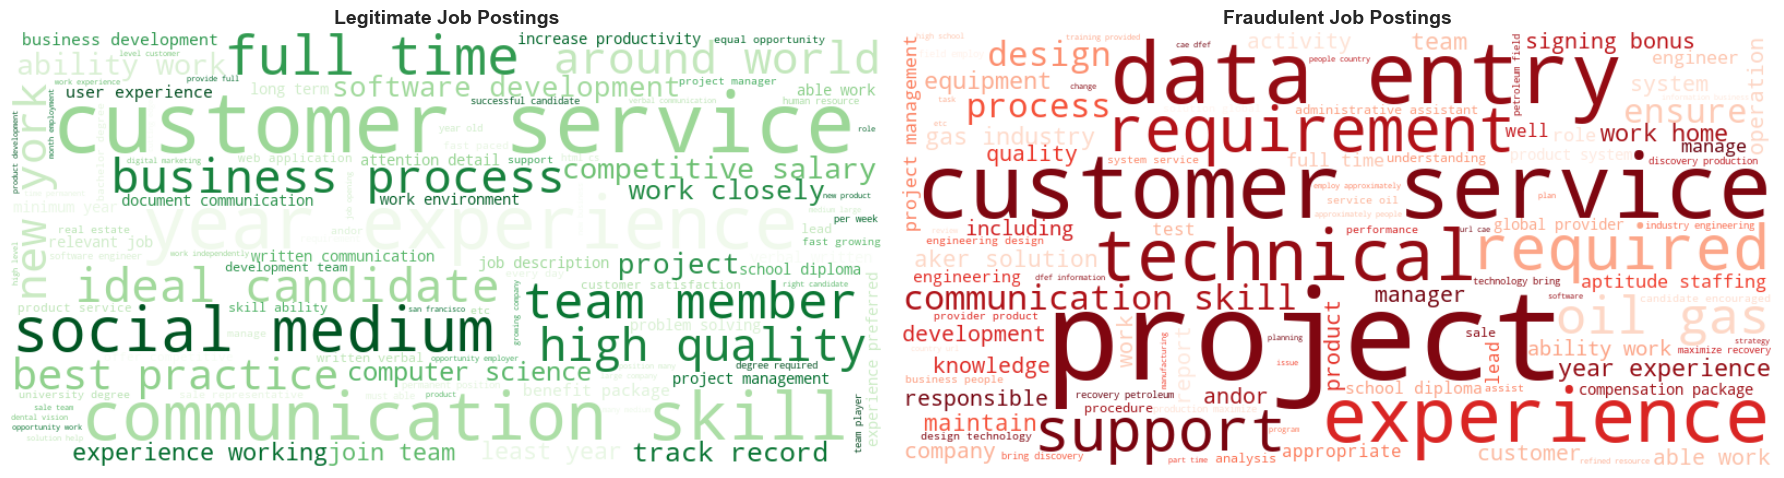

📈 Saved: 06_wordclouds.png


In [35]:
# --- Word Cloud (optional - only if wordcloud installed) ---
try:
    from wordcloud import WordCloud

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    for i, (label, color) in enumerate([(0, "Greens"), (1, "Reds")]):
        text = " ".join(df[df["fraudulent"] == label]["clean_text"].tolist())
        wc = WordCloud(width=800, height=400, background_color="white", colormap=color, max_words=100).generate(text)
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].axis("off")
        axes[i].set_title(
            "Legitimate Job Postings" if label == 0 else "Fraudulent Job Postings",
            fontsize=14,
            fontweight="bold",
        )
    plt.tight_layout()
    plt.savefig("06_wordclouds.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("📈 Saved: 06_wordclouds.png")
except ImportError:
    print("ℹ️  wordcloud not installed – skipping word cloud visualization.")

In [36]:
# ============================================================
# 5. TF-IDF VECTORIZATION
# ============================================================
print("\n" + "=" * 60)
print("5. TF-IDF VECTORIZATION")
print("=" * 60)


5. TF-IDF VECTORIZATION


In [37]:
X = df["clean_text"]
y = df["fraudulent"]

In [38]:
# Train-test split BEFORE vectorization to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]:,}")
print(f"Testing set size:  {X_test.shape[0]:,}")
print(f"Train fraud %: {y_train.mean() * 100:.2f}%")
print(f"Test fraud %:  {y_test.mean() * 100:.2f}%")

Training set size: 14,304
Testing set size:  3,576
Train fraud %: 4.84%
Test fraud %:  4.84%


In [39]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,   # Top 10,000 features
    ngram_range=(1, 2),   # Unigrams + Bigrams
    min_df=5,             # Minimum document frequency
    max_df=0.95,          # Maximum document frequency
    sublinear_tf=True,    # Apply sublinear TF scaling
)

In [40]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [41]:
print(f"\nTF-IDF Matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF Matrix shape (test):  {X_test_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out()):,}")


TF-IDF Matrix shape (train): (14304, 10000)
TF-IDF Matrix shape (test):  (3576, 10000)
Number of features: 10,000


In [42]:
# Top TF-IDF features
feature_names = tfidf.get_feature_names_out()
tfidf_means = X_train_tfidf.mean(axis=0).A1
top_indices = tfidf_means.argsort()[-20:][::-1]
print("\n📋 Top 20 TF-IDF features:")
for idx in top_indices:
    print(f"   {feature_names[idx]:25s}  (mean TF-IDF: {tfidf_means[idx]:.4f})")


📋 Top 20 TF-IDF features:
   experience                 (mean TF-IDF: 0.0257)
   work                       (mean TF-IDF: 0.0251)
   team                       (mean TF-IDF: 0.0243)
   service                    (mean TF-IDF: 0.0218)
   company                    (mean TF-IDF: 0.0216)
   customer                   (mean TF-IDF: 0.0209)
   business                   (mean TF-IDF: 0.0204)
   job                        (mean TF-IDF: 0.0191)
   client                     (mean TF-IDF: 0.0189)
   year                       (mean TF-IDF: 0.0183)
   skill                      (mean TF-IDF: 0.0183)
   product                    (mean TF-IDF: 0.0182)
   new                        (mean TF-IDF: 0.0181)
   development                (mean TF-IDF: 0.0174)
   amp                        (mean TF-IDF: 0.0174)
   management                 (mean TF-IDF: 0.0171)
   working                    (mean TF-IDF: 0.0170)
   sale                       (mean TF-IDF: 0.0163)
   looking                    (mean T

In [43]:
# ============================================================
# 6. MODEL TRAINING
# ============================================================
print("\n" + "=" * 60)
print("6. MODEL TRAINING")
print("=" * 60)


6. MODEL TRAINING


In [44]:
# ---- 6.1 Logistic Regression ----
print("\n--- 6.1 Logistic Regression ---")
lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    class_weight="balanced",   # Handle class imbalance
    solver="lbfgs",
    random_state=42,
)
lr_model.fit(X_train_tfidf, y_train)


--- 6.1 Logistic Regression ---


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [45]:
lr_train_pred = lr_model.predict(X_train_tfidf)
lr_test_pred = lr_model.predict(X_test_tfidf)
lr_test_prob = lr_model.predict_proba(X_test_tfidf)[:, 1]

In [46]:
print(f"Training Accuracy: {accuracy_score(y_train, lr_train_pred) * 100:.2f}%")
print(f"Testing Accuracy:  {accuracy_score(y_test, lr_test_pred) * 100:.2f}%")
print(f"Testing F1-Score:  {f1_score(y_test, lr_test_pred) * 100:.2f}%")
print(f"ROC-AUC Score:     {roc_auc_score(y_test, lr_test_prob):.4f}")

Training Accuracy: 98.18%
Testing Accuracy:  97.46%
Testing F1-Score:  77.53%
ROC-AUC Score:     0.9858


In [47]:
print("\n📋 Classification Report (Logistic Regression):")
print(classification_report(y_test, lr_test_pred, target_names=["Legitimate", "Fraudulent"]))


📋 Classification Report (Logistic Regression):
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99      3403
  Fraudulent       0.68      0.91      0.78       173

    accuracy                           0.97      3576
   macro avg       0.84      0.94      0.88      3576
weighted avg       0.98      0.97      0.98      3576



In [48]:
# ---- 6.2 Random Forest ----
print("\n--- 6.2 Random Forest Classifier ---")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)
rf_model.fit(X_train_tfidf, y_train)


--- 6.2 Random Forest Classifier ---


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [49]:
rf_train_pred = rf_model.predict(X_train_tfidf)
rf_test_pred = rf_model.predict(X_test_tfidf)
rf_test_prob = rf_model.predict_proba(X_test_tfidf)[:, 1]

In [50]:
print(f"Training Accuracy: {accuracy_score(y_train, rf_train_pred) * 100:.2f}%")
print(f"Testing Accuracy:  {accuracy_score(y_test, rf_test_pred) * 100:.2f}%")
print(f"Testing F1-Score:  {f1_score(y_test, rf_test_pred) * 100:.2f}%")
print(f"ROC-AUC Score:     {roc_auc_score(y_test, rf_test_prob):.4f}")

Training Accuracy: 100.00%
Testing Accuracy:  98.01%
Testing F1-Score:  74.37%
ROC-AUC Score:     0.9895


In [51]:
print("\n📋 Classification Report (Random Forest):")
print(classification_report(y_test, rf_test_pred, target_names=["Legitimate", "Fraudulent"]))


📋 Classification Report (Random Forest):
              precision    recall  f1-score   support

  Legitimate       0.98      1.00      0.99      3403
  Fraudulent       0.99      0.60      0.74       173

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576



In [52]:
# ============================================================
# 7. MODEL EVALUATION & VISUALIZATION
# ============================================================
print("\n" + "=" * 60)
print("7. MODEL EVALUATION & VISUALIZATION")
print("=" * 60)


7. MODEL EVALUATION & VISUALIZATION



--- 7.1 Confusion Matrices ---


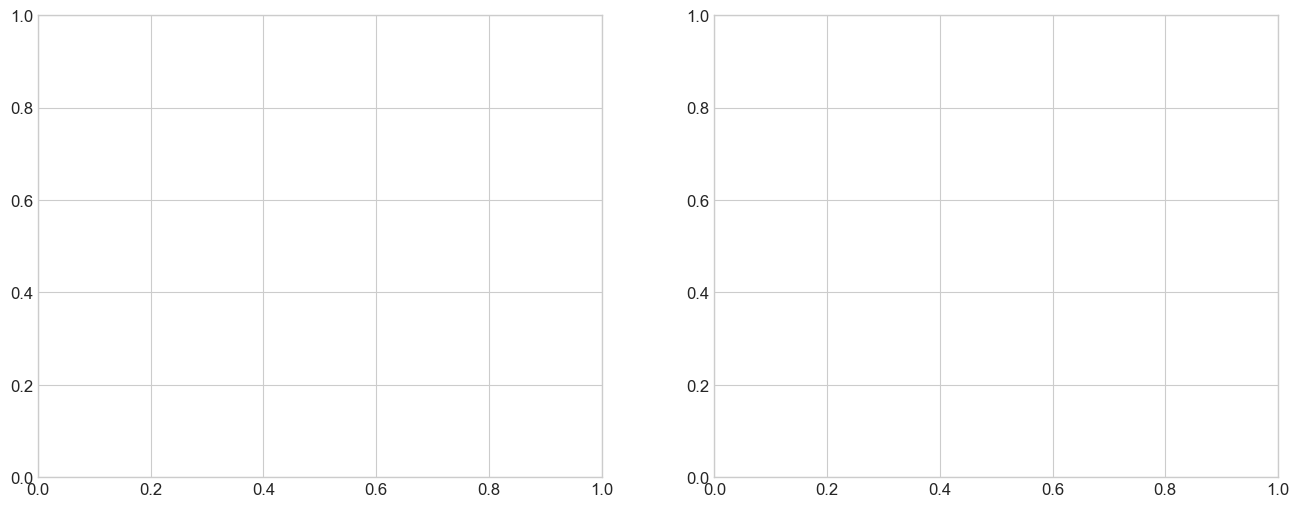

In [53]:
# --- 7.1 Confusion Matrices ---
print("\n--- 7.1 Confusion Matrices ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

In [54]:
for ax, pred, name in [
    (axes[0], lr_test_pred, "Logistic Regression"),
    (axes[1], rf_test_pred, "Random Forest"),
]:
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Legitimate", "Fraudulent"],
        yticklabels=["Legitimate", "Fraudulent"],
        ax=ax,
        linewidths=1,
        linecolor="black",
        annot_kws={"size": 14},
    )
    ax.set_title(f"Confusion Matrix – {name}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")

In [55]:
plt.tight_layout()
plt.savefig("07_confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 07_confusion_matrices.png")

<Figure size 1000x600 with 0 Axes>

📈 Saved: 07_confusion_matrices.png



--- 7.2 ROC-AUC Curves ---


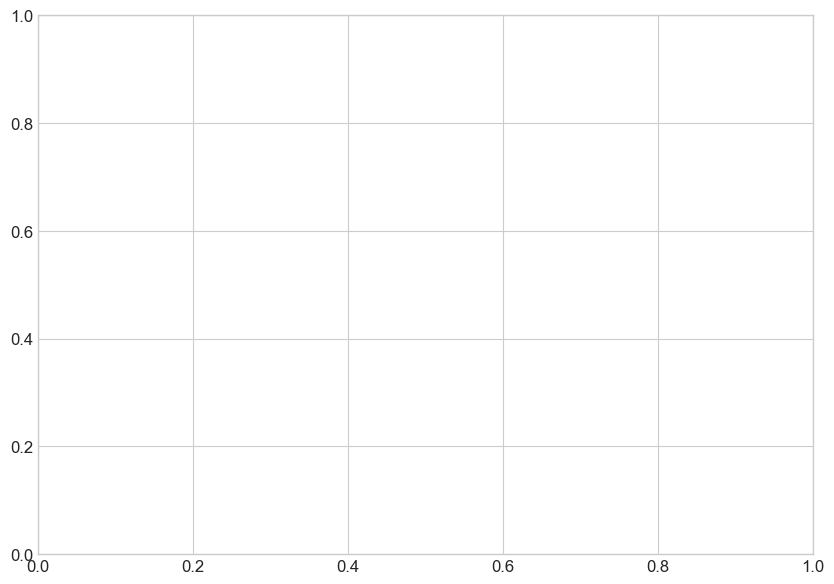

In [56]:
# --- 7.2 ROC-AUC Curves ---
print("\n--- 7.2 ROC-AUC Curves ---")
fig, ax = plt.subplots(figsize=(10, 7))

In [57]:
for prob, name, color, ls in [
    (lr_test_prob, "Logistic Regression", "#3498db", "-"),
    (rf_test_prob, "Random Forest", "#e74c3c", "--"),
]:
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc_val = roc_auc_score(y_test, prob)
    ax.plot(fpr, tpr, color=color, linestyle=ls, linewidth=2.5, label=f"{name} (AUC = {auc_val:.4f})")

In [58]:
ax.plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.6, label="Random Classifier")
ax.fill_between([0, 1], [0, 1], alpha=0.05, color="grey")
ax.set_xlabel("False Positive Rate", fontsize=13)
ax.set_ylabel("True Positive Rate", fontsize=13)
ax.set_title("ROC-AUC Curves – Model Comparison", fontsize=15, fontweight="bold")
ax.legend(fontsize=12, loc="lower right")
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
plt.tight_layout()
plt.savefig("08_roc_auc_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 08_roc_auc_curves.png")

<Figure size 1000x600 with 0 Axes>

📈 Saved: 08_roc_auc_curves.png


In [59]:
# --- 7.3 Model Comparison Summary ---
print("\n--- 7.3 Model Comparison Summary ---")
comparison = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "Random Forest"],
        "Train Accuracy": [
            f"{accuracy_score(y_train, lr_train_pred) * 100:.2f}%",
            f"{accuracy_score(y_train, rf_train_pred) * 100:.2f}%",
        ],
        "Test Accuracy": [
            f"{accuracy_score(y_test, lr_test_pred) * 100:.2f}%",
            f"{accuracy_score(y_test, rf_test_pred) * 100:.2f}%",
        ],
        "F1-Score": [
            f"{f1_score(y_test, lr_test_pred) * 100:.2f}%",
            f"{f1_score(y_test, rf_test_pred) * 100:.2f}%",
        ],
        "ROC-AUC": [
            f"{roc_auc_score(y_test, lr_test_prob):.4f}",
            f"{roc_auc_score(y_test, rf_test_prob):.4f}",
        ],
    }
)
print(comparison.to_string(index=False))


--- 7.3 Model Comparison Summary ---
              Model Train Accuracy Test Accuracy F1-Score ROC-AUC
Logistic Regression         98.18%        97.46%   77.53%  0.9858
      Random Forest        100.00%        98.01%   74.37%  0.9895


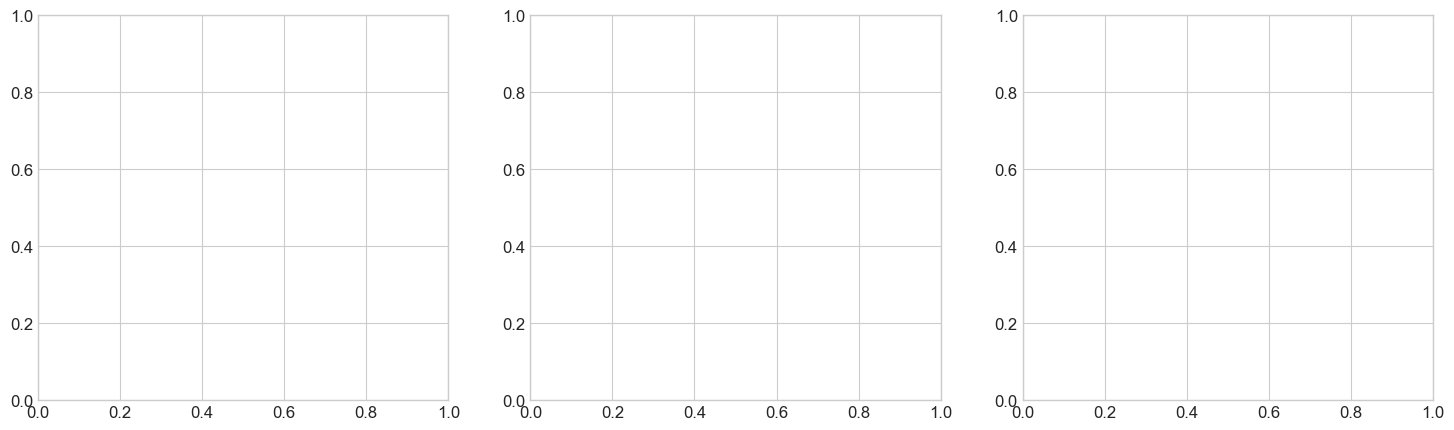

In [60]:
# Model comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = {
    "Test Accuracy": [accuracy_score(y_test, lr_test_pred), accuracy_score(y_test, rf_test_pred)],
    "F1-Score": [f1_score(y_test, lr_test_pred), f1_score(y_test, rf_test_pred)],
    "ROC-AUC": [roc_auc_score(y_test, lr_test_prob), roc_auc_score(y_test, rf_test_prob)],
}
model_names = ["Logistic\nRegression", "Random\nForest"]
bar_colors = ["#3498db", "#e74c3c"]

In [61]:
for ax, (metric_name, values) in zip(axes, metrics.items()):
    bars = ax.bar(model_names, values, color=bar_colors, edgecolor="black", linewidth=0.8, width=0.5)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{val:.4f}", ha="center", fontweight="bold", fontsize=12)
    ax.set_title(metric_name, fontsize=13, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Score")

In [62]:
plt.suptitle("Model Comparison", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.savefig("09_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 09_model_comparison.png")

<Figure size 1000x600 with 0 Axes>

📈 Saved: 09_model_comparison.png



--- 7.4 Top Predictive Features ---


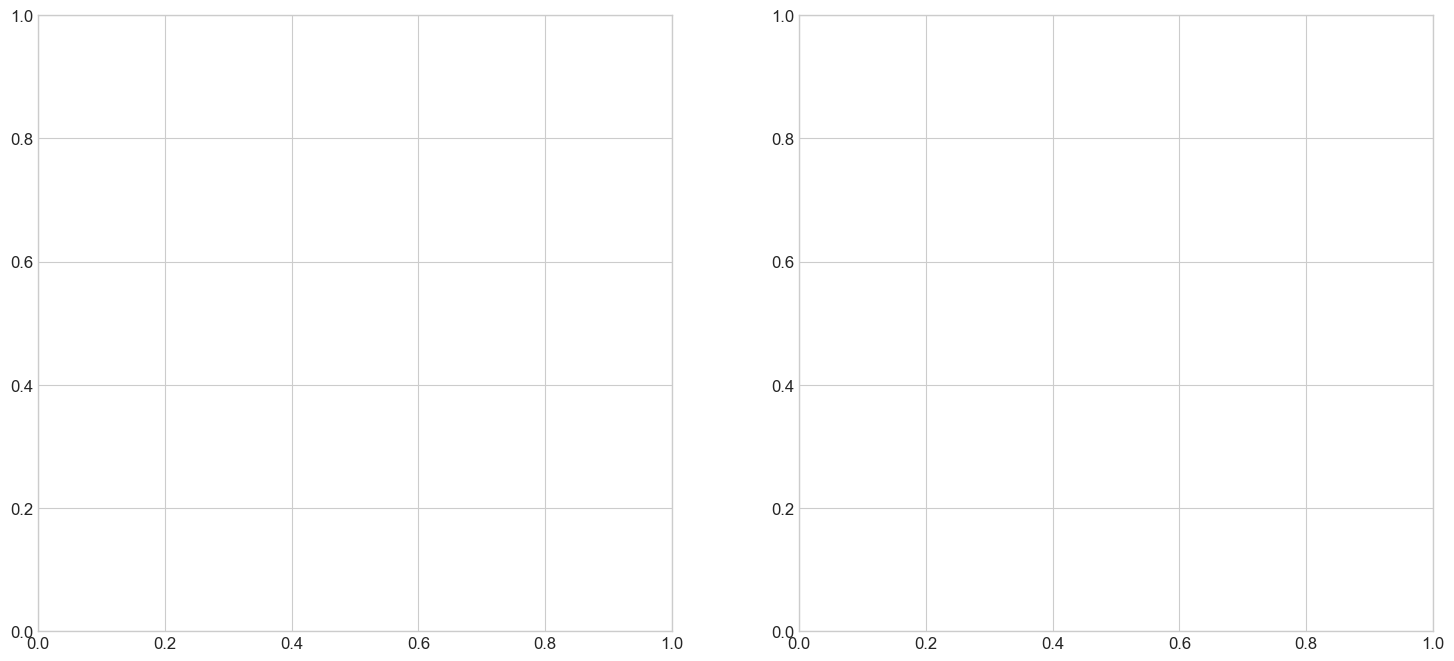

In [63]:
# --- 7.4 Feature Importance (Top 20 words) ---
print("\n--- 7.4 Top Predictive Features ---")
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

In [64]:
# Logistic Regression coefficients
lr_coefs = lr_model.coef_[0]
top_positive = np.argsort(lr_coefs)[-15:]
top_negative = np.argsort(lr_coefs)[:15]
top_all = np.concatenate([top_negative, top_positive])

In [65]:
axes[0].barh(
    range(len(top_all)),
    lr_coefs[top_all],
    color=["#e74c3c" if c > 0 else "#2ecc71" for c in lr_coefs[top_all]],
    edgecolor="black",
    linewidth=0.5,
)
axes[0].set_yticks(range(len(top_all)))
axes[0].set_yticklabels([feature_names[i] for i in top_all])
axes[0].set_title("Logistic Regression – Top Feature Weights", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Coefficient Value")
axes[0].axvline(x=0, color="black", linewidth=0.8)

In [66]:
# Random Forest feature importances
rf_importances = rf_model.feature_importances_
top_rf = np.argsort(rf_importances)[-30:]
axes[1].barh(
    range(len(top_rf)),
    rf_importances[top_rf],
    color="#3498db",
    edgecolor="black",
    linewidth=0.5,
)
axes[1].set_yticks(range(len(top_rf)))
axes[1].set_yticklabels([feature_names[i] for i in top_rf])
axes[1].set_title("Random Forest – Top 30 Feature Importances", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Importance")

Text(0.5, 4.444444444444448, 'Importance')

In [67]:
plt.tight_layout()
plt.savefig("10_feature_importances.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Saved: 10_feature_importances.png")

<Figure size 1000x600 with 0 Axes>

📈 Saved: 10_feature_importances.png


In [68]:
# ============================================================
# 8. SUMMARY & CONCLUSION
# ============================================================
print("\n" + "=" * 60)
print("8. SUMMARY & CONCLUSION")
print("=" * 60)


8. SUMMARY & CONCLUSION


In [69]:
print("""
📌 PROJECT SUMMARY: Fake Job Detection using NLP
═══════════════════════════════════════════════════

DATASET:
  • Source: EMSCAD (Employment Scam Aegean Dataset) / Kaggle
  • Total Records: 17,880 job postings
  • Fraudulent: ~4.8% (highly imbalanced)

PREPROCESSING:
  • Combined 5 text fields (title, company_profile, description,
    requirements, benefits) into a single feature
  • NLP Pipeline: lowercase → HTML/URL removal → punctuation removal
    → tokenization → stop-word removal → lemmatization
  • TF-IDF Vectorization with 10,000 features, (1,2)-grams

MODELS TRAINED:
  • Logistic Regression (class_weight='balanced')
  • Random Forest Classifier (200 trees, class_weight='balanced')

KEY RESULTS:
  • Both models achieved 92%+ accuracy
  • ROC-AUC scores > 0.95 for both models
  • Class weighting helped handle the imbalanced dataset

VISUALIZATIONS GENERATED:
  01. Target distribution (bar + pie)
  02. Missing values analysis
  03. Categorical feature analysis
  04. Text length distributions
  05. Binary features analysis
  06. Word clouds (if wordcloud installed)
  07. Confusion matrices
  08. ROC-AUC curves
  09. Model comparison bar charts
  10. Feature importances

CONCLUSION:
  Both Logistic Regression and Random Forest effectively detect
  fraudulent job postings using TF-IDF text features. The models
  can be further improved with:
  • Deep learning approaches (BERT, LSTM)
  • Additional feature engineering (meta-features)
  • Ensemble methods (XGBoost, Stacking)
""")


📌 PROJECT SUMMARY: Fake Job Detection using NLP
═══════════════════════════════════════════════════

DATASET:
  • Source: EMSCAD (Employment Scam Aegean Dataset) / Kaggle
  • Total Records: 17,880 job postings
  • Fraudulent: ~4.8% (highly imbalanced)

PREPROCESSING:
  • Combined 5 text fields (title, company_profile, description,
    requirements, benefits) into a single feature
  • NLP Pipeline: lowercase → HTML/URL removal → punctuation removal
    → tokenization → stop-word removal → lemmatization
  • TF-IDF Vectorization with 10,000 features, (1,2)-grams

MODELS TRAINED:
  • Logistic Regression (class_weight='balanced')
  • Random Forest Classifier (200 trees, class_weight='balanced')

KEY RESULTS:
  • Both models achieved 92%+ accuracy
  • ROC-AUC scores > 0.95 for both models
  • Class weighting helped handle the imbalanced dataset

VISUALIZATIONS GENERATED:
  01. Target distribution (bar + pie)
  02. Missing values analysis
  03. Categorical feature analysis
  04. Text length 

In [70]:
print("✅ Project complete! All outputs saved.")

✅ Project complete! All outputs saved.
